In [1]:
import networkx as nx
import pyro.distributions as dist
import matplotlib.pylab as plt
import numpy as np
import sys
sys.path.append("/home/folzd/phd/compositions_mixtures_factors")
from model_operators import *
from utils import *
from code_generation import *
from graph_grammar import *
from models_and_guides import *

In [2]:
%load_ext autoreload

%autoreload 2

In [81]:
factor = nx.DiGraph()

In [82]:
nodes = [
    #('z_loc',{'type':'const', 'value':0.}),
    #('z_scale',{'type':'const', 'value':1.}),
    ('z_loc',{'type':'function', 'function':torch.zeros, 'args':(Name(id='K'),)}),
    ('z_scale',{'type':'function', 'function':torch.ones, 'args':(Name(id='K'),)}),
    ('z',{'distribution':dist.Normal,'type':'latent','event_dims':1}),
    #('z_T',{'type':'deterministic', 'function':torch.transpose, 'args':(Num(0),Num(1))}),
    #('z_T',{'type':'function', 'function':torch.transpose, 'args':(Num(0),Num(1))}),
    ('cov_diag_loc',{'type':'param','shape':'D'}),
    ('cov_diag_scale',{'type':'param','shape':'D','constraint':'positive'}),
#    ('cov_factor_loc',{'type':'param','shape':'KD'}),
#    ('cov_factor_scale',{'type':'param','shape':'KD','constraint':'positive'}),
    ('cov_factor_loc',{'type':'param','shape':'DK'}),
    ('cov_factor_scale',{'type':'param','shape':'DK','constraint':'positive'}),
    ('cov_factor',{'distribution':dist.Normal,'type':'latent','event_dims':2}),
    #('Wz',{'type':'deterministic', 'function':torch.matmul}),
    ('Wz',{'type':'function', 'function':torch.matmul, 'args':('p','t')}),
    ('X',{'distribution':dist.MultivariateNormal,'type':'obs'}),
    ('cov_diag',{'distribution':dist.LogNormal,'type':'latent','event_dims':1}),
    #('diag',{'type':'deterministic', 'function':torch.diag_embed}),
    ('diag',{'type':'function', 'function':torch.diag_embed}),
]

In [83]:
edges = [
    ('cov_diag_loc','cov_diag',{'type':'param','param':'loc'}),
    ('cov_diag_scale','cov_diag',{'type':'param','param':'scale'}),
    ('cov_factor_loc','cov_factor',{'type':'param','param':'loc'}),
    ('cov_factor_scale','cov_factor',{'type':'param','param':'scale'}),
    ('z_loc','z',{'type':'param','param':'loc'}),
    ('z_scale','z',{'type':'param','param':'scale'}),    
    #('z','Wz',{'type':'arg', 'transpose':True}),
#    ('z','z_T',{'type':'arg'}),
#    ('z_T','Wz',{'type':'arg'}),
    ('z','Wz',{'type':'arg'}),
    ('cov_factor','Wz',{'type':'arg'}),
    ('Wz','X',{'type':'param','param':'loc'}),
    #('cov_diag','X',{'type':'param','param':'scale'})
    ('cov_diag','diag',{'type':'arg'}),
    ('diag','X',{'type':'param','param':'covariance_matrix'})
]

In [84]:
plate_attr = {
#    'cov_factor':{'plates':['D','K']},
#    'cov_diag':{'plates':['D']},
    'X':{'plates':['N']},
    'Wz':{'plates':['N']},
    #'z':{'plates':['N','K']},
    'z':{'plates':['N']},
    #'z_T':{'plates':['N']}
}

In [85]:
factor.add_nodes_from(nodes)
factor.add_edges_from(edges)
nx.set_node_attributes(factor, plate_attr)

W: D, K

z: K, N

Sigma: D

Wz: N

X: N

In [86]:
nx.get_node_attributes(factor, 'plates')

{'z': ['N'], 'Wz': ['N'], 'X': ['N']}

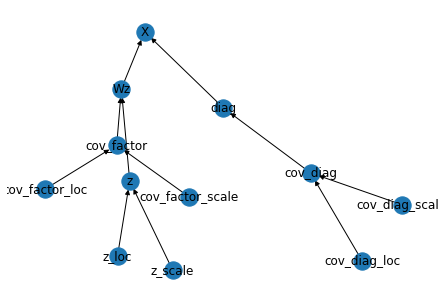

In [87]:
nx.draw(factor, with_labels=True)

In [88]:
generate_Model_class(factor)

In [36]:
pyro.clear_param_store()

In [37]:
from model import DAGModel

In [38]:
N = 1000
D = 10
K = 4

In [39]:
dagmodel = DAGModel(torch.zeros(N,D),K,N,'id')

In [40]:
dagmodel.batch_size = N

In [41]:
tmp = dagmodel.model(torch.zeros(N,D))

In [42]:
tmp.shape

torch.Size([1000, 10])

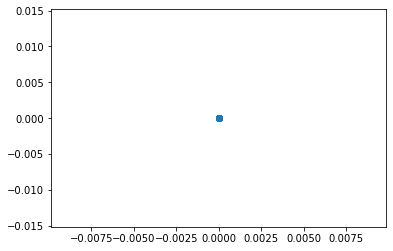

In [43]:
plt.scatter(*tmp[:,:2].detach().T)

In [44]:
foo = dagmodel.unconditioned_model(torch.zeros(N,D))

In [45]:
pyro.clear_param_store()

In [46]:
pyro.set_rng_seed(42)

zeroMeanFactor_teacher = ZeroMeanFactor(torch.empty(N,D), K, N, '0')

dgp = zeroMeanFactor_teacher.unconditioned_model
trace = pyro.poutine.trace(dgp).get_trace(torch.empty(N,D))
true_variables = dict([(name,trace.nodes[name]["value"]) for name in trace.stochastic_nodes if len(name)>1])
X = true_variables['obs'].detach()

data, test_data = train_test_split(X)

In [47]:
data.shape

torch.Size([900, 10])

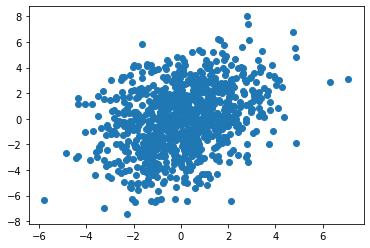

In [48]:
plt.scatter(*data[:,:2].T)

In [49]:
from inference import *

In [59]:
config = dict(
        n_iter = 10000,
        learning_rate = 0.01, 
        beta1 = 0.9,
        beta2 = 0.999,
        learning_rate_decay = 1., # no decay by default
        batch_size = 32, 
        n_elbo_particles = 1, 
        n_posterior_samples = 1024,
        window = 500,
        convergence_window = 30,
        slope_significance = 0.1,
        track_params = False,
        monitor_gradients = False,
        telemetry = None
    )

In [60]:
telemetry = inference(dagmodel, data, test_data, config=config)



NLL after 0/10000 iterations is 27.829086303710938
...........................................................................................................................................................................................................................................................................................................................................................................................................\Interrupted by user after 395 iterations.



In [67]:
dagmodel.sample_posterior_predictive(N)

RuntimeError: size mismatch, m1: [4 x 10], m2: [4 x 1] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:136
            Trace Shapes:           
             Param Sites:           
cov_factor_prior_scale_id 10  4     
  cov_factor_prior_loc_id 10  4     
  cov_diag_prior_scale_id    10     
    cov_diag_prior_loc_id    10     
            Sample Sites:           
       cov_factor_id dist     | 10 4
                    value  1  | 10 4
         cov_diag_id dist     | 10  
                    value  1  | 10  
                N_id dist     |     
                    value  1  |     
                z_id dist  1  |  4  
                    value  1  |  4  

In [68]:
%debug

> /home/folzd/phd/experiments/model.py(55)model()
     53             z = pyro.sample(f'z_{_id}', dist.Normal(z_prior_loc, z_prior_scale)
     54                 .to_event(1))
---> 55             Wz = torch.matmul(z, cov_factor.T)
     56             X = pyro.sample('obs', dist.MultivariateNormal(Wz, diag), obs=X.
     57                 index_select(0, ind))

ipdb> z.shape
torch.Size([1, 4])
ipdb> cov_factor.shape
torch.Size([1, 10, 4])
ipdb> Wz
*** NameError: name 'Wz' is not defined
ipdb> torch.matmul(z, cov_factor.T)
*** RuntimeError: size mismatch, m1: [4 x 10], m2: [4 x 1] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:136
ipdb> cov_factor.T.shape
torch.Size([4, 10, 1])
ipdb> cov_factor.transpose(-2,-1).shape
torch.Size([1, 4, 10])
ipdb> torch.matmul(z, cov_factor.transpose(-2,-1))
tensor([[[ 0.9137, -0.4246, -0.4779, -1.4862, -1.7216,  0.6354,  0.4548,
           0.6664, -0.8623, -2.1510]]], grad_fn=<TransposeBackward0>)
ipdb> c


In [69]:
foo = dagmodel.posterior_predictive(data)

RuntimeError: size mismatch, m1: [4 x 10], m2: [4 x 1] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:136
            Trace Shapes:           
             Param Sites:           
cov_factor_prior_scale_id 10  4     
  cov_factor_prior_loc_id 10  4     
  cov_diag_prior_scale_id    10     
    cov_diag_prior_loc_id    10     
            Sample Sites:           
       cov_factor_id dist     | 10 4
                    value  1  | 10 4
         cov_diag_id dist     | 10  
                    value  1  | 10  
                N_id dist     |     
                    value  1  |     
                z_id dist  1  |  4  
                    value  1  |  4  

In [ ]:
foo['cov_factor_id'].shape

In [63]:
foo['cov_diag_id'].shape

IndexError: too many indices for tensor of dimension 2

In [64]:
foo['obs'].shape

IndexError: too many indices for tensor of dimension 2

In [65]:
foo['z_id'].shape

IndexError: too many indices for tensor of dimension 2

In [ ]:
rand_idx = np.random.choice(10,2, replace=False)

rand_idx

plt.scatter(*data[:,rand_idx].T)
plt.scatter(*foo['obs'][:,0,0,rand_idx].squeeze().T.detach())

In [ ]:
plt.plot(telemetry['loss'])

In [ ]:
plt.plot(telemetry['MNLL'])

In [110]:
marg_factor = marginalize_factor(factor)

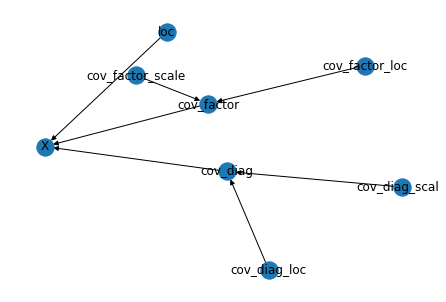

In [111]:
nx.draw(marg_factor, with_labels=True)

In [112]:
nx.get_node_attributes(marg_factor,'plates')

{'X': ['N']}

In [113]:
generate_Model_class(marg_factor)

In [114]:
from model import DAGModel

pyro.clear_param_store()
dagmodel = DAGModel(torch.zeros(N,D),K,N,'id')
tmp = dagmodel.model(torch.zeros(N,D))

In [115]:
config = dict(
        n_iter = 10000,
        learning_rate = 0.01, 
        beta1 = 0.9,
        beta2 = 0.999,
        learning_rate_decay = 1., # no decay by default
        batch_size = 32, 
        n_elbo_particles = 20, 
        n_posterior_samples = 1024,
        window = 500,
        convergence_window = 30,
        slope_significance = 0.1,
        track_params = False,
        monitor_gradients = False,
        telemetry = None
    )

In [116]:
telemetry = inference(dagmodel, data, test_data, config=config)



NLL after 0/10000 iterations is 26.733522415161133
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [117]:
dagmodel.sample_posterior_predictive(N)

foo = dagmodel.posterior_predictive(data)

foo['obs'].shape

torch.Size([1000, 32, 10])

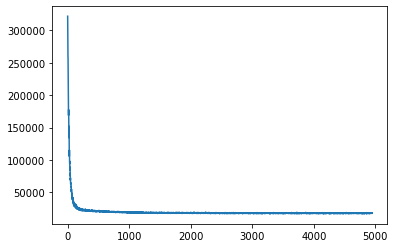

In [118]:
plt.plot(telemetry['loss'])

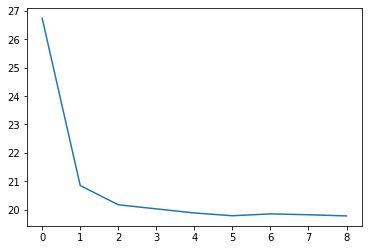

In [119]:
plt.plot(telemetry['MNLL'])

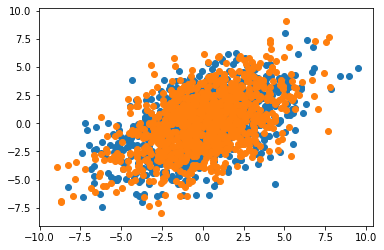

In [107]:
rand_idx = np.random.choice(10,2, replace=False)

rand_idx

plt.scatter(*data[:,rand_idx].T)
plt.scatter(*foo['obs'][:,0,rand_idx].squeeze().T.detach())

In [ ]:
marg_factor

In [ ]:
list(marg_factor.predecessors('X'))

In [ ]:
mixture = mixture_from_marg_factor(marg_factor)

In [ ]:
nx.draw(mixture, with_labels=True)

In [ ]:
nx.get_node_attributes(mixture, 'plates')

In [ ]:
nx.get_node_attributes(mixture, 'shape')

In [ ]:
plate = ''.join(mixture.nodes['cov_factor']['plates'])

In [ ]:
#generate_Model_class(marg_factor)
generate_Model_class(mixture)

In [ ]:
from model import DAGModel

In [ ]:
pyro.clear_param_store()
C = 2
dagmodel = DAGModel(torch.zeros(N,D),K,C,N,'id')
tmp = dagmodel.model(torch.zeros(N,D))

In [ ]:
dagmodel.param_shapes_and_support

In [ ]:
dgp = dagmodel.unconditioned_model
trace = pyro.poutine.trace(dgp).get_trace(torch.empty(N,D))
true_variables = dict([(name,trace.nodes[name]["value"]) for name in trace.stochastic_nodes if len(name)>1])

new_dgp = pyro.poutine.condition(dgp, data={'loc_id':true_variables['loc_id']*3})
trace = pyro.poutine.trace(new_dgp).get_trace(torch.empty(N,D))

true_variables = dict([(name,trace.nodes[name]["value"]) for name in trace.stochastic_nodes if len(name)>1])
X = true_variables['obs'].detach()
Xz = torch.cat([X,true_variables['assignment_id'].detach().float().unsqueeze(-1)],dim=-1)
Xzdata, Xztest_data = train_test_split(Xz)
data, train_assign = Xzdata[:,:-1],Xzdata[:,-1]
test_data, test_assign = Xztest_data[:,:-1],Xztest_data[:,-1]

In [ ]:
rand_idx = np.random.choice(10,2, replace=False)

rand_idx

plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
#plt.scatter(*foo['obs'][:,0,0,rand_idx].squeeze().T.detach())

In [ ]:
config = dict(
        n_iter = 10000,
        learning_rate = 0.01, 
        beta1 = 0.9,
        beta2 = 0.999,
        learning_rate_decay = 1., # no decay by default
        batch_size = 32, 
        n_elbo_particles = 1, 
        n_posterior_samples = 1024,
        window = 500,
        convergence_window = 30,
        slope_significance = 0.1,
        track_params = False,
        monitor_gradients = False,
        telemetry = None
    )

In [ ]:
telemetry = inference(dagmodel, data, test_data, config=config)

In [ ]:
%debug

In [ ]:
dagmodel.sample_posterior_predictive(N)

In [ ]:
foo = dagmodel.posterior_predictive(data)

foo['obs'].shape

In [ ]:
plt.plot(telemetry['loss'])

In [ ]:
foo['obs'].shape

In [ ]:
foo['assignment_id'].shape

In [ ]:
#plt.scatter(*data[:,rand_idx].T)
#plt.scatter(*foo['obs'][:,0,0,0,rand_idx].squeeze().T.detach())

#plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
plt.scatter(*foo['obs'][:,0,0,0,rand_idx].squeeze().T.detach(),c=foo['assignment_id'][:,0,0,0].squeeze().T.detach())
